In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, simplify

## Consider the $g$ that arises from the ode
$$
\dot{x} = \lambda +x - x^3
$$
namely, 

$$
f(x) = -x^2, \quad x \neq 0
$$

$$
g(x,\lambda) = \frac{1}{x} \left(\frac{\lambda}{x}+1\right)
$$

$$
\partial_x g(x,l) = - \frac{1}{x^3}(2\lambda + x)
$$

# To do 
 - load data
 - load model
 - do contraction sweep
 - scaled data
 - create plots

In [27]:
def g_true(x,lam):
    return (1/x)*((lam / x) + 1)

def dgdx(x, lam):
    return -(1/ x**3) *(2 *lam+x)

def ode_rhs(x, lam):
    return lam+x-x**3

/tmp/ipykernel_31051/3984022047.py:5: RuntimeWarning: divide by zero encountered in divide
  return -(1/ x**3) *(2 *lam+x)


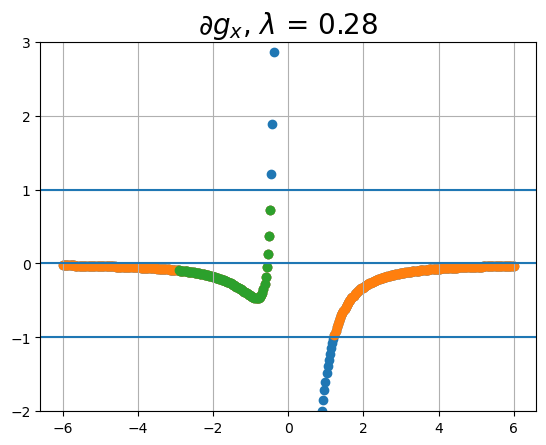

In [66]:
lam = 0.28
# lam = 3
xs = np.linspace(-6,6,401)
threshold = 0.1 # Define a threshold, e.g., anything between -0.5 and 0.5 will be zero

out = np.abs(dgdx(xs, lam))
mask1 = out < 1
mask2 = out > 0
mask = mask1 & mask2

xs = np.where(np.abs(xs) < threshold, 0, xs)
plt.axhline(1)
plt.axhline(0)
plt.axhline(-1)
plt.scatter(xs, dgdx(xs, lam))
plt.scatter(xs[mask], dgdx(xs[mask], lam))
plt.scatter(np.array(xvals), dgdx(np.array(xvals), lam))
plt.grid(True)
plt.title(rf"$\partial g_x$, $\lambda$ = {lam}", size=20)
# plt.axvline(-np.sqrt(4/27)-0.08)
# plt.axvline(-1)
# plt.axvline(1.2)
plt.ylim(-2,3)
plt.show()

In [70]:
def contraction(x0, lam,iterations=100):
    try:
        # Explicitly catch RuntimeWarnings
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)  # Treat RuntimeWarnings as exceptions

            g_vals = [x0]
            iters = 100
            xi = g_vals[0]
            for iter in range(iterations):
                xi = g_true(xi, lam)
                # print(xi)
                g_vals.append(xi)
            return True, g_vals

    except RuntimeWarning as e:
        # print("runtime", e)
        return False, False
    except Exception as e:
        # print("other",e)
        return False, False

# contraction(4,3)
mappings = []
xvals = []
for x0 in xs[mask]:
    flag, g_vals = contraction(x0, lam=0.28)
    if flag:
        xvals.append(x0)
        mappings.append(g_vals)

xvals = np.array(xvals)

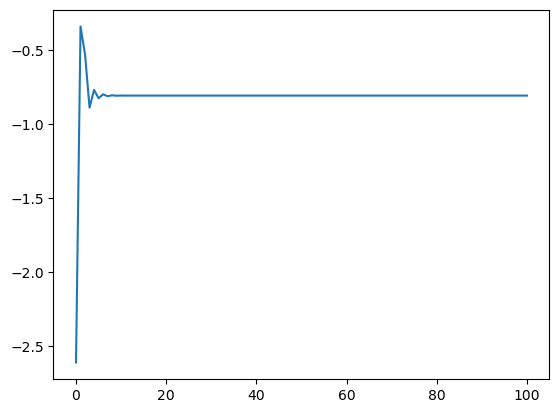

In [75]:
plt.plot(mappings[10])

In [85]:
from stabnode.node import _load_model_opt
import torch
path = "../results/july_17/seed_1234_sample_rate_10_lr_0.1_n_epochs_300_hidden_dim_2_patience_100.pt"

model, opt, epoch, loss = _load_model_opt(path)

In [86]:
g = model.g

g.eval()

GTerm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Tanh()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [93]:
with torch.no_grad():
    g(torch.tensor([1]),torch.tensor([1]))

RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

In [30]:
coeff_func = lambda lam: [-1,0,1,2*lam]

def real_roots(coeffs):
    roots = np.roots(coeffs)
    return sorted([r.real for r in roots if np.isreal(r)])

real_roots(coeff_func(lam))


[1.2211966861810777]

In [31]:
def descrim(lam):
    a = -1
    b = 0
    c = 1
    d = lam
    p = (3*a*c-b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

    return - (4*p**3 + 27*q**2)
    

In [32]:
lam = symbols('lam')

a = -1
b = 0
c = 1
d = lam
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = -  (4*p**3 + 27*q**2)
D = simplify(D)

solve(Eq(D,0), lam)
lam1, lam2 = -np.sqrt(4/27), np.sqrt(4/27)

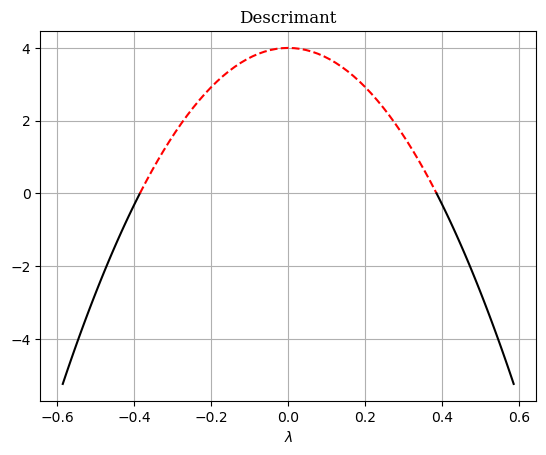

In [33]:
lam_vals = np.linspace(lam1-0.2, lam2+0.2, 51)

lam_neg = np.linspace(lam1-0.2, lam1, 51)
lam_pos = np.linspace(lam1, lam2, 51)
lam_neg2 = np.linspace(lam2, lam2+0.2,51)

plt.plot(lam_neg, descrim(lam_neg), color='black')
plt.plot(lam_pos, descrim(lam_pos), color='red', linestyle='--')
plt.plot(lam_neg2, descrim(lam_neg2),color='black')
plt.title("Descrimant", family='serif')
plt.xlabel(r"$\lambda$")
plt.grid(True)
plt.show()

## Bifurcation plots

In [35]:
def ode_coeff(lam):
    a = -1
    b = 0
    c = 1
    d = lam
    return [a,b,c,d]

def real_roots(coeffs):
    roots = np.roots(coeffs)
    return sorted([r.real for r in roots if np.isreal(r)])

[-0.808506228591646, -0.3097064495076063, 1.118212678099253]


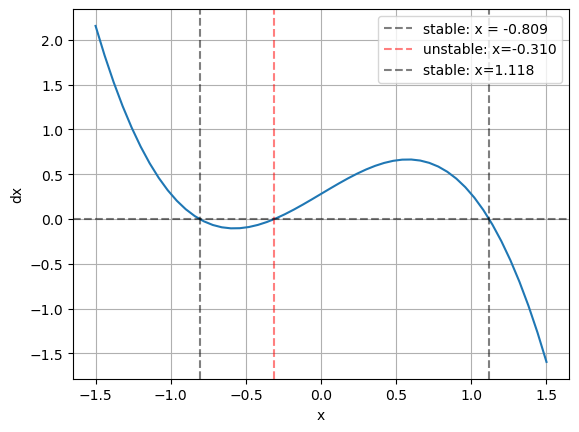

In [36]:
lam = np.sqrt(4/27)-0.001
lam= 0.28
roots = real_roots(ode_coeff(lam))
print(roots)
xs = np.linspace(-1.5,1.5,51)
plt.plot(xs, ode_rhs(xs,lam))
plt.axvline(roots[0], color='black',linestyle='--', alpha=0.5, label=f"stable: x = {roots[0]:.3f}")
if len(roots) == 3:
    plt.axvline(roots[1], color='red', linestyle="--", alpha=0.5, label=f"unstable: x={roots[1]:.3f}")
    plt.axvline(roots[2], color='black',linestyle='--', alpha=0.5, label = f"stable: x={roots[2]:.3f}")
plt.axhline(0,color='black', linestyle="--", alpha=0.5)
plt.xlabel("x")
plt.ylabel("dx")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
end_point = np.sqrt(4/27)+0.1
end_point = 2
lam_up = np.linspace(-2, end_point, 200)
lam_down = np.linspace(end_point, -2, 200)
lam_vals = np.hstack((lam_up,lam_down))
def lam_func(idx):
    idx = idx % len(lam_vals)
    return lam_vals[idx]

In [38]:
# plt.plot(lam_func(np.arange(800)))

In [39]:
lam= np.sqrt(4/27)
lam = 0.28

In [40]:
x0 = -1
# x0 =-0.5
x0 = 0.5
# x0 = 1.5
# x0=2

In [41]:
import warnings

success = []
for x0 in xs[mask]:
    try:
        # Explicitly catch RuntimeWarnings
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)  # Treat RuntimeWarnings as exceptions

            g_vals = [x0]
            iters = 100
            xi = g_vals[0]
            for iter in range(iters):
                xi = g_true(xi, lam)
                g_vals.append(xi)

        success.append(True)  # If no warning occurs, append success
    except RuntimeWarning as e:
        success.append(False)  # If a RuntimeWarning occurs, append failure
    except Exception as e:
        success.append(False)  # Handle other exceptions


IndexError: boolean index did not match indexed array along dimension 0; dimension is 51 but corresponding boolean dimension is 401

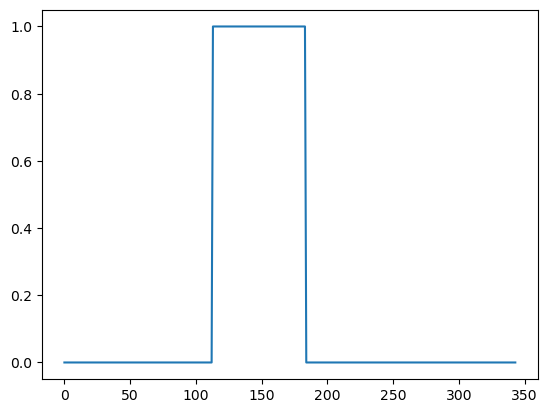

In [23]:
plt.plot(success)

In [24]:
success = []
for x0 in xs:
    try: 
        g_vals = [x0]
        iters = 100
        xi = g_vals[0]
        for iter in range(iters):
            xi = g_true(xi,lam)
            g_vals.append(xi)
        success.append(True)
    except Exception as e:
        sucess.append(False)
        

/tmp/ipykernel_31051/3984022047.py:2: RuntimeWarning: overflow encountered in scalar multiply
  return (1/x)*((lam / x) + 1)
/tmp/ipykernel_31051/3984022047.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/x)*((lam / x) + 1)


In [25]:
success

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

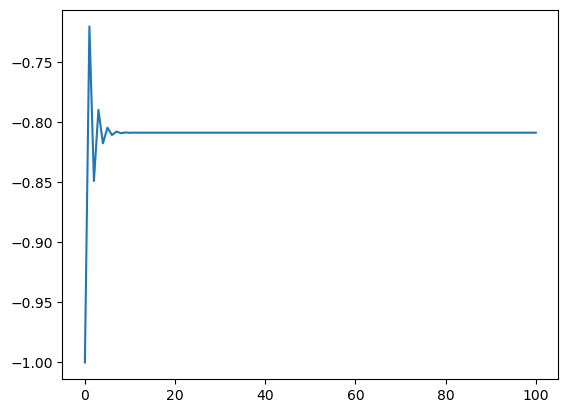

In [123]:
plt.plot(g_vals)

In [124]:
g_vals

[-1,
 -0.72,
 -0.8487654320987653,
 -0.7895103471074381,
 -0.8174051239931551,
 -0.8043167098735435,
 -0.810474800285522,
 -0.8075803177204635,
 -0.8089415325336194,
 -0.8083015326448745,
 -0.8086024745368233,
 -0.8084609725928199,
 -0.8085275080338883,
 -0.8084962228598584,
 -0.8085109333285759,
 -0.8085040163995673,
 -0.8085072687748847,
 -0.8085057394922918,
 -0.8085064585685521,
 -0.8085061204553707,
 -0.808506279437855,
 -0.8085062046835096,
 -0.8085062398333706,
 -0.8085062233057331,
 -0.8085062310771096,
 -0.8085062274229701,
 -0.8085062291411645,
 -0.808506228333261,
 -0.8085062287131413,
 -0.8085062285345197,
 -0.8085062286185084,
 -0.8085062285790166,
 -0.8085062285975859,
 -0.8085062285888543,
 -0.80850622859296,
 -0.8085062285910295,
 -0.8085062285919372,
 -0.8085062285915104,
 -0.8085062285917112,
 -0.8085062285916167,
 -0.8085062285916612,
 -0.8085062285916401,
 -0.8085062285916501,
 -0.8085062285916454,
 -0.8085062285916477,
 -0.8085062285916466,
 -0.808506228591647,
 -0